In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357280 sha256=b6b0b6236f628b936c3a6d44291b3c7ddec896105df369c394b1bd968a635df4
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
from mlxtend.frequent_patterns import apriori, association_rules
from surprise import Dataset, Reader, SVD
from surprise.model_selection import GridSearchCV, train_test_split
from surprise import accuracy
import scipy

In [2]:
original_movies= pd.read_csv('movies.csv', delimiter='::', encoding='ISO-8859-1')
original_users= pd.read_csv('users.csv', delimiter='::')
original_ratings= pd.read_csv('ratings.csv', delimiter='::')

C:\Users\user\AppData\Local\Temp\ipykernel_15528\2471538762.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  original_movies= pd.read_csv('movies.csv', delimiter='::', encoding='ISO-8859-1')
C:\Users\user\AppData\Local\Temp\ipykernel_15528\2471538762.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  original_users= pd.read_csv('users.csv', delimiter='::')
C:\Users\user\AppData\Local\Temp\ipykernel_15528\2471538762.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); 

# EDA

In [3]:
print(original_movies.info(), "\n")
print(original_users.info(), "\n")
print(original_ratings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieid  3883 non-null   int64 
 1   title    3883 non-null   object
 2   genres   3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   userid      6040 non-null   int64 
 1   gender      6040 non-null   object
 2   age         6040 non-null   int64 
 3   occupation  6040 non-null   int64 
 4   zip-code    6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   userid   

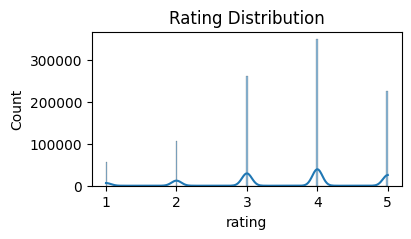

In [4]:
plt.figure(figsize=(4, 2))
sns.histplot(original_ratings['rating'], kde=True)
plt.title('Rating Distribution')
plt.show()

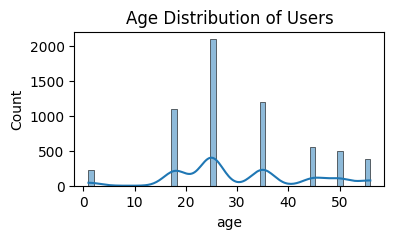

In [5]:
plt.figure(figsize=(4, 2))
sns.histplot(original_users['age'], kde=True)
plt.title('Age Distribution of Users')
plt.show()

In [6]:
print("Males:",original_users[original_users['gender'] == 'M'].shape[0])
print("Females:",original_users[original_users['gender'] == 'F'].shape[0])

Males: 4331
Females: 1709


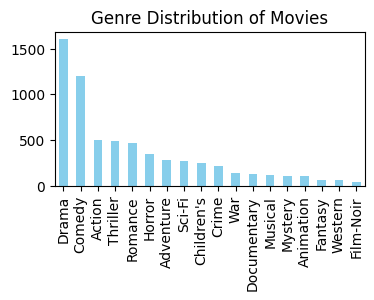

In [7]:
movie_genres = original_movies['genres'].str.split('|', expand=True).stack().value_counts()
plt.figure(figsize=(4, 2))
movie_genres.plot(kind='bar', title='Genre Distribution of Movies', color='skyblue')

plt.show()

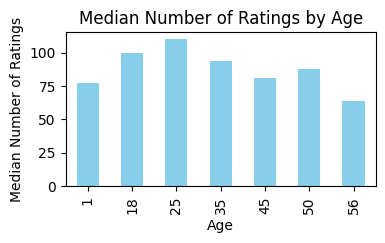

In [8]:
user_ratings_count = original_ratings['userid'].value_counts().reset_index()
user_ratings_count.columns = ['userid', 'ratings_count']

original_users_ratings_count = pd.merge(original_users, user_ratings_count, on='userid')
age_ratings_count_median = original_users_ratings_count.groupby('age')['ratings_count'].median()

plt.figure(figsize=(4, 2))
age_ratings_count_median.plot(kind='bar', color='skyblue')
plt.title('Median Number of Ratings by Age')
plt.xlabel('Age')
plt.ylabel('Median Number of Ratings')
plt.show()

# Data Preparation

## Data Cleaning

In [9]:
# deleting users having rated more than 110 movies
users= original_users_ratings_count[original_users_ratings_count['ratings_count'] <= 110]
valid_users=users.index
ratings = original_ratings[original_ratings['userid'].isin(valid_users)]
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 560784 entries, 53 to 999724
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   userid     560784 non-null  int64
 1   movieid    560784 non-null  int64
 2   rating     560784 non-null  int64
 3   timestamp  560784 non-null  int64
dtypes: int64(4)
memory usage: 21.4 MB


In [10]:
movie_ratings_count = original_ratings['movieid'].value_counts()

print("Highest number of ratings for a movie:", movie_ratings_count.max())
print("Lowest number of ratings for a movie:", movie_ratings_count.min())

Highest number of ratings for a movie: 3428
Lowest number of ratings for a movie: 1


In [11]:
# # Supprimer les films ayant reçu moins de 'min_ratings_threshold' notations
# min_ratings_threshold = 600

# # Vérifiez si 'movie_ratings_count' est une série avec les 'movieid' comme index
# popular_movies = movie_ratings_count[movie_ratings_count >= min_ratings_threshold].index

# # Filtrer les évaluations pour inclure uniquement ces films populaires
# ratings = ratings[ratings['movieid'].isin(popular_movies)]

# # Filtrer les informations de films pour inclure uniquement les films populaires
# movies = original_movies[original_movies['movieid'].isin(popular_movies)]

#deleting movies rated less than threshold times, since popular movies ratings weight more==> better clustering/recommendation
min_ratings_threshold = 600
popular_movies = movie_ratings_count[movie_ratings_count >= min_ratings_threshold].index

# Filter the ratings to include only these popular movies
ratings = ratings[ratings['movieid'].isin(popular_movies)]
movies = original_movies[original_movies['movieid'].isin(popular_movies)]

In [12]:
movie_ratings_count = ratings['movieid'].value_counts()

print("Highest number of ratings for a movie:", movie_ratings_count.max())
print("Lowest number of ratings for a movie:", movie_ratings_count.min())

Highest number of ratings for a movie: 1925
Lowest number of ratings for a movie: 312


In [13]:
users['gender'] = users['gender'].map({'M': 0, 'F': 1})

C:\Users\user\AppData\Local\Temp\ipykernel_15528\903805772.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users['gender'] = users['gender'].map({'M': 0, 'F': 1})


original median:  4.0 new median:  4.0


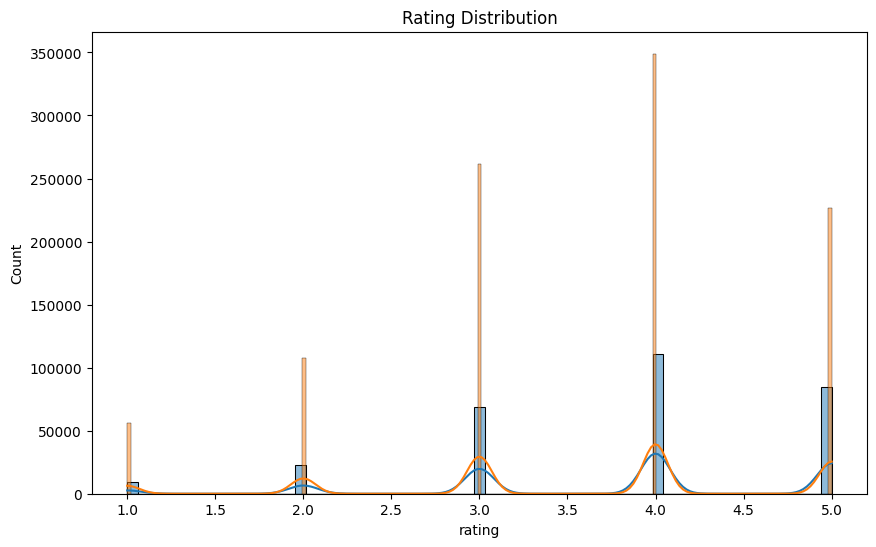

In [14]:
# making sure the new movies datset still preserves the original data characteristics and covers the same rating percentages

print("original median: ",ratings['rating'].median(),"new median: ",original_ratings['rating'].median())
plt.figure(figsize=(10, 6))
sns.histplot(ratings['rating'], kde=True)
sns.histplot(original_ratings['rating'], kde=True)
plt.title('Rating Distribution')
plt.show()


## Feature Engineering

In [15]:
ratings.drop(columns=['timestamp'], inplace=True)
users.drop(columns=['zip-code'], inplace=True)
movies.drop(columns=['title'], inplace=True)
users.drop(columns=['ratings_count'], inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_15528\3766339797.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users.drop(columns=['zip-code'], inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_15528\3766339797.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies.drop(columns=['title'], inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_15528\3766339797.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users.drop(

In [16]:
print("ratings: ",ratings.shape)
print("movies: ",movies.shape)
print("users: ",users.shape)

ratings:  (295943, 3)
movies:  (499, 2)
users:  (3346, 4)


In [ ]:
movies_genres = movies['genres'].str.get_dummies('|')
movies = pd.concat([movies[['movieid']], movies_genres], axis=1)
ratings_with_genres = pd.merge(ratings, movies, on='movieid')
data = pd.merge(ratings_with_genres, users, on='userid')
for genre in movies_genres:
    data[genre] = data.apply(lambda row: row['rating'] if row[genre] == 1 else 0, axis=1)
data.head()

In [ ]:
genre_columns = movies_genres.columns.tolist()
# user_genres_ratings = data.groupby('userid')[genre_columns].mean()
user_genres_ratings = data.groupby('userid')[genre_columns].agg(lambda x: x[x > 0].mean())
user_genres_ratings[genre_columns] = user_genres_ratings[genre_columns].fillna(0)
user_genres_ratings= pd.merge(user_genres_ratings, users, on='userid')
user_genres_ratings.head()

In [ ]:
pd.plotting.scatter_matrix(user_genres_ratings,figsize=(12,12))

# Clustering

## PCA

In [ ]:
scaler = StandardScaler()
user_genres_ratings_scaled = scaler.fit_transform(user_genres_ratings[genre_columns])
pca = PCA(n_components=4)
genre_pca = pca.fit_transform(user_genres_ratings_scaled)

genre_pca_df = pd.DataFrame(genre_pca, columns=[f'PCA_{i+1}' for i in range(4)])
user_genres_ratings_pca = pd.concat([user_genres_ratings.reset_index(drop=True), genre_pca_df], axis=1)
user_genres_ratings_pca.head()

,userid,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,...,Thriller,War,Western,gender,age,occupation,PCA_1,PCA_2,PCA_3,PCA_4
0,3,4.12500,4.105263,4.0,4.000000,3.954545,0.00,0.0,4.000000,4.5,...,3.500000,4.000000,4.750000,0,25,15,1.184871,1.809736,-1.401691,-1.033505
1,6,4.00000,3.800000,4.0,4.000000,3.875000,2.00,0.0,3.642857,3.0,...,3.500000,4.000000,3.666667,1,50,9,0.187476,2.126853,-1.473945,0.384844
2,12,3.80000,5.000000,0.0,5.000000,3.600000,3.50,0.0,4.333333,0.0,...,4.333333,3.000000,0.000000,0,25,12,-0.516239,0.293040,0.911955,0.658713
3,13,3.45614,3.436364,3.0,3.428571,3.000000,3.25,0.0,3.894737,3.4,...,3.473684,4.222222,3.000000,0,45,1,0.305605,0.867484,0.318170,-1.151343
4,20,4.31250,3.750000,0.0,0.000000,4.000000,4.75,0.0,4.600000,0.0,...,4.222222,4.666667,0.000000,0,25,14,1.063999,-2.913332,0.795623,0.810881


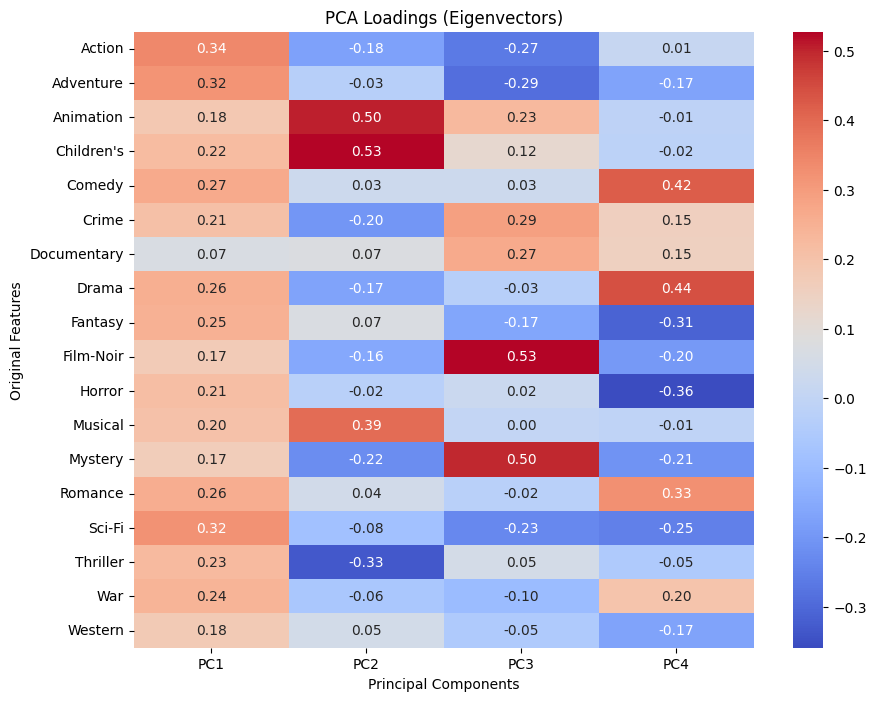

In [ ]:
loadings = pca.components_  # Eigenvectors
features = genre_columns
num_components = len(loadings)

loadings_df = pd.DataFrame(loadings.T, columns=[f'PC{i+1}' for i in range(num_components)], index=features)

# Plot heatmap of eigenvectors
plt.figure(figsize=(10, 8))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('PCA Loadings (Eigenvectors)')
plt.xlabel('Principal Components')
plt.ylabel('Original Features')
plt.show()

In [ ]:
print(pca.explained_variance_ratio_)
print(f"Total Explained Variance: {sum(pca.explained_variance_ratio_)}")

[0.20536211 0.10113552 0.0865816  0.07045275]
Total Explained Variance: 0.46353197739262997


## t-SNE

In [ ]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
tsne2 = TSNE(n_components=2, perplexity=50, random_state=42) #50
tsne1 = TSNE(n_components=2,perplexity=25, random_state=42) #, 25
# user_genres_ratings.drop(columns=['userid'], inplace=True)
# user_genres_ratings_pca.drop(columns=['userid'], inplace=True)

In [ ]:
#Calculate correlations between t-SNE components and our variables
def corr(tsne_df,data):

    correlations = pd.DataFrame(
        {f't-SNE Component {i+1}': [
            np.corrcoef(tsne_df[f't-SNE Component {i+1}'], data[col])[0, 1]
            for col in data.columns
        ] for i in range(tsne_df.shape[1])},
        index=data.columns
    )

    # heatmap of the correlations
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlations, annot=True, cmap="coolwarm", center=0, fmt=".2f")
    # plt.title("Correlation of t-SNE Components with Original Variables")
    # plt.ylabel("Original Variables")
    # plt.xlabel("t-SNE Components")
    # plt.show()

    #bar plot showing the absolute correlation for each t-SNE component
    for i in range(tsne_df.shape[1]):
        plt.figure(figsize=(3, 3))
        abs_corr = correlations[f't-SNE Component {i+1}'].abs()
        abs_corr.sort_values(ascending=False).plot(kind='bar', color='skyblue')
        # plt.title(f"Absolute Correlation of t-SNE Component {i+1} with Original Variables")
        # plt.ylabel("Absolute Correlation")
        # plt.xlabel("Original Variables")
        plt.show()

### application on original variables

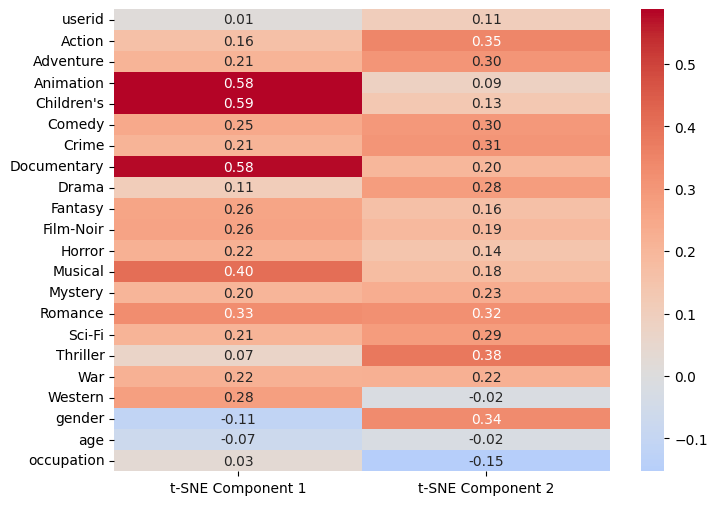

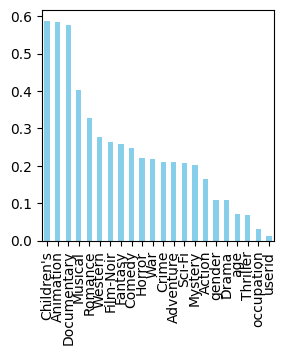

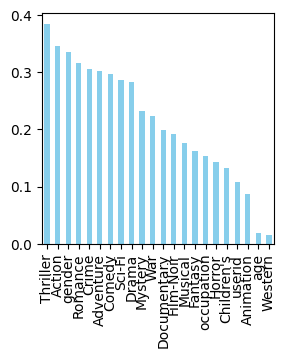

In [ ]:
user_genres_ratings_scaled = scaler.fit_transform(user_genres_ratings)
tsne_results = tsne1.fit_transform(user_genres_ratings_scaled)

tsne_df=pd.DataFrame(
        tsne_results,
        columns=['t-SNE Component 1', 't-SNE Component 2']
    )

user_genres_ratings_scaled_df = pd.DataFrame(
    user_genres_ratings_scaled,
    columns=user_genres_ratings.columns,
    index=user_genres_ratings.index
)
corr(tsne_df,user_genres_ratings_scaled_df)

In [ ]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import trustworthiness

trust = trustworthiness(user_genres_ratings_scaled_df, tsne_results)
print(f"t-SNE Trustworthiness: {trust}")

t-SNE Trustworthiness: 0.9630063642307438


In [ ]:
loveM = int(user_genres_ratings[((user_genres_ratings['Thriller'] >= 5) | (user_genres_ratings['Action'] >= 5)) & (user_genres_ratings['gender'] == 0)].shape[0])
# loveM = int(data[((data['Animation'] ==0) | (data['Film-Noir'] == 0)| (data['Children\'s'] == 0)| (data['Mystery'] == 0)) & (data['gender'] == 0)].shape[0])

loveF = int(user_genres_ratings[((user_genres_ratings['Thriller'] >= 5) | (user_genres_ratings['Action'] >= 5)) & (user_genres_ratings['gender'] == 1)].shape[0])
# loveF = int(data[((data['Thriller'] == 0) | (data['Action'] == 0)| (data['Romance'] == 0)| (data['Crime'] == 0)| (data['Adventure'] >= 1)| (data['Comedy'] == 0)| (data['Sci-Fi'] == 0)| (data['Drama'] == 0)) & (data['gender'] == 1)].shape[0])

# loveF = int(data[((data['Thriller'] >= 1) | (data['Action'] >= 1)) & (data['gender'] == 1)].shape[0])
# nopeF = int(data[((data['Thriller'] == 0) | (data['Action'] == 0)) & (data['gender'] == 1)].shape[0])
# loveM = int(data[((data['Romance'] >= 1)) & (data['gender'] == 0)].shape[0])
# nopeF = int(data[((data['Romance'] == 0)) & (data['gender'] == 0)].shape[0])

# loveF = int(data[((data['Romance'] >= 1)) & (data['gender'] == 1)].shape[0])
# nopeF = int(data[((data['Romance'] == 0)) & (data['gender'] == 1)].shape[0])
# doc = user_genres_ratings[user_genres_ratings['Adventure'] >= 4].shape[0]
# doc = data[data['Thriller'] >= 1].shape[0]

# # count=data.shape[0]
# # perc=anime/count
# # perc
# # corr(tsne_df,user_genres_ratings_scaled_df)
# # data.head()
print(loveM/user_genres_ratings[((user_genres_ratings['Thriller'] >= 1) | (user_genres_ratings['Action'] >= 1)) &(user_genres_ratings['gender']==0)].shape[0])
print(loveF/user_genres_ratings[((user_genres_ratings['Thriller'] >= 1) | (user_genres_ratings['Action'] >= 1)) &(user_genres_ratings['gender']==1)].shape[0])
print(user_genres_ratings[user_genres_ratings['gender']==1].shape[0],user_genres_ratings[user_genres_ratings['gender']==0].shape[0])
# doc

0.0544435548438751
0.09185441941074524
579 1251


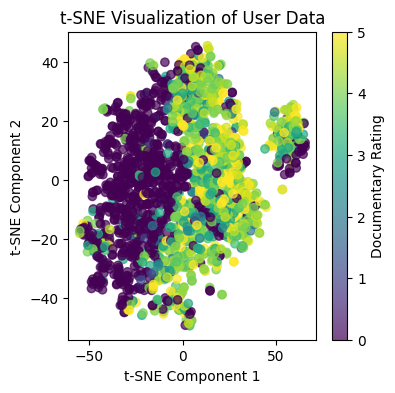

In [ ]:
# Plotting the results
plt.figure(figsize=(4, 4))
plt.scatter(tsne_df['t-SNE Component 1'], tsne_df['t-SNE Component 2'], alpha=0.7, c=user_genres_ratings['Animation'], cmap='viridis')
plt.colorbar(label='Documentary Rating')
plt.title('t-SNE Visualization of User Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

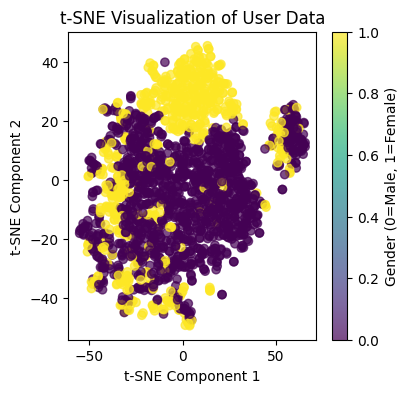

In [ ]:
# Plotting the results
plt.figure(figsize=(4, 4))
plt.scatter(tsne_df['t-SNE Component 1'], tsne_df['t-SNE Component 2'], alpha=0.7, c=user_genres_ratings['gender'], cmap='viridis')
plt.colorbar(label='Gender (0=Male, 1=Female)')
plt.title('t-SNE Visualization of User Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

### appliccation on categorical + pca variables

#### gender

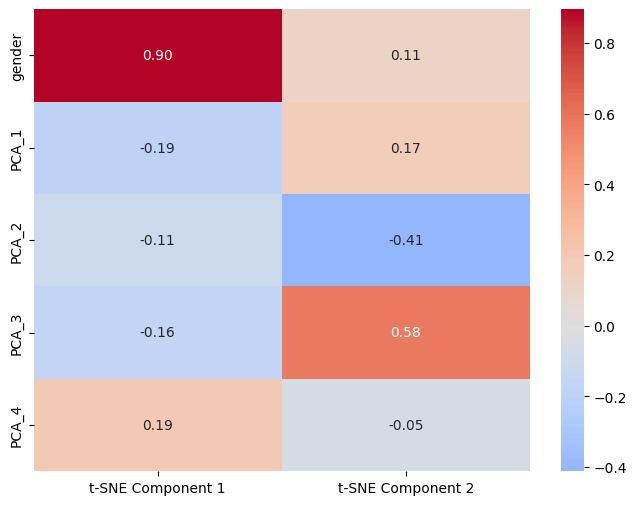

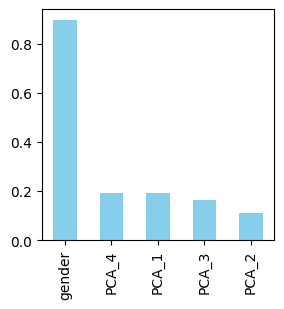

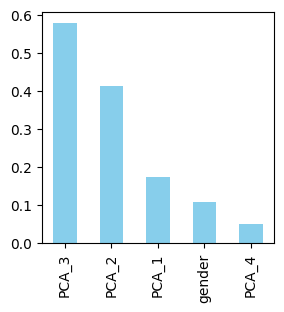

In [ ]:
user_genres_ratings_pca_only1=user_genres_ratings_pca[['gender','PCA_1','PCA_2','PCA_3','PCA_4']]
user_genres_ratings_pca_only_scaled1 = scaler.fit_transform(user_genres_ratings_pca_only1)
tsne_pca_only_results1 = tsne1.fit_transform(user_genres_ratings_pca_only_scaled1)

tsne_pca_only_df1=pd.DataFrame(
        tsne_pca_only_results1,
        columns=['t-SNE Component 1', 't-SNE Component 2']
    )

user_genres_ratings_pca_only_scaled_df1 = pd.DataFrame(
    user_genres_ratings_pca_only_scaled1,
    columns=user_genres_ratings_pca_only1.columns,
    index=user_genres_ratings_pca_only1.index
)

corr(tsne_pca_only_df1,user_genres_ratings_pca_only_scaled_df1)

In [ ]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import trustworthiness

trust = trustworthiness(user_genres_ratings_pca_only_scaled_df1, tsne_pca_only_results1)
print(f"t-SNE Trustworthiness: {trust}")

t-SNE Trustworthiness: 0.9973405193356247


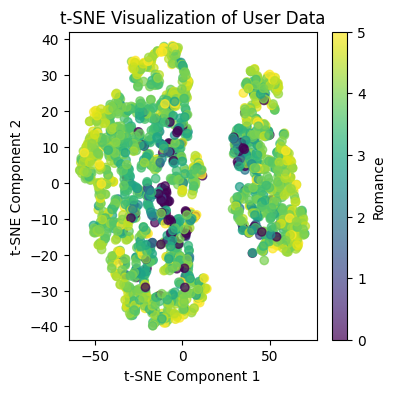

In [ ]:
plt.figure(figsize=(4, 4))
plt.scatter(tsne_pca_only_df1['t-SNE Component 1'], tsne_pca_only_df1['t-SNE Component 2'], alpha=0.7, c=user_genres_ratings_pca['Romance'], cmap='viridis')
plt.colorbar(label='Romance')
plt.title('t-SNE Visualization of User Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

#### Age

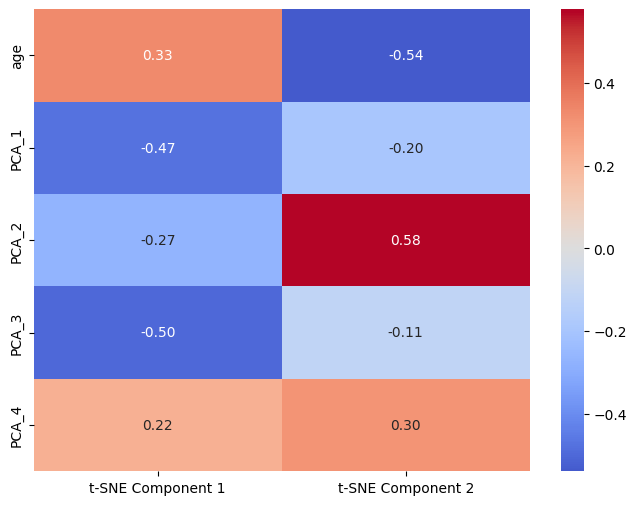

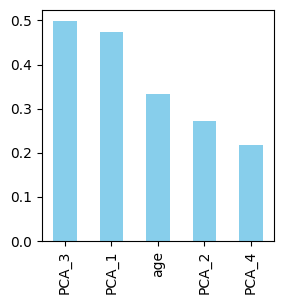

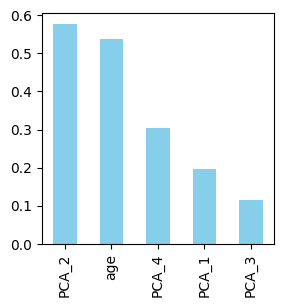

In [ ]:
user_genres_ratings_pca_only2=user_genres_ratings_pca[['age','PCA_1','PCA_2','PCA_3','PCA_4']]
user_genres_ratings_pca_only_scaled2 = scaler.fit_transform(user_genres_ratings_pca_only2)
tsne_pca_only_results2 = tsne2.fit_transform(user_genres_ratings_pca_only_scaled2)

tsne_pca_only_df2=pd.DataFrame(
        tsne_pca_only_results2,
        columns=['t-SNE Component 1', 't-SNE Component 2']
    )

user_genres_ratings_pca_only_scaled_df2 = pd.DataFrame(
    user_genres_ratings_pca_only_scaled2,
    columns=user_genres_ratings_pca_only2.columns,
    index=user_genres_ratings_pca_only2.index
)

corr(tsne_pca_only_df2,user_genres_ratings_pca_only_scaled_df2)

In [ ]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import trustworthiness

trust = trustworthiness(user_genres_ratings_pca_only_scaled_df2, tsne_pca_only_results2)
print(f"t-SNE Trustworthiness: {trust}")

t-SNE Trustworthiness: 0.9927715295147949


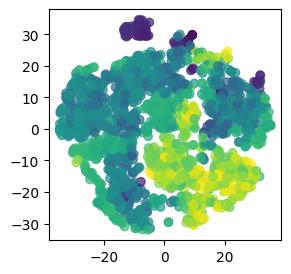

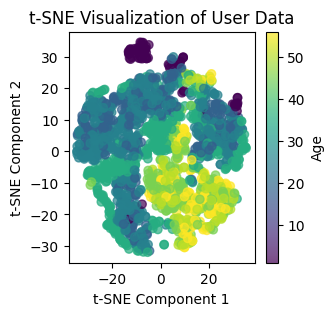

In [ ]:
plt.figure(figsize=(3, 3))
composite_genre = user_genres_ratings_pca['Drama']+user_genres_ratings_pca['Romance']+user_genres_ratings_pca['Comedy']+user_genres_ratings_pca['War']+user_genres_ratings_pca['age']
plt.scatter(tsne_pca_only_df2['t-SNE Component 1'], tsne_pca_only_df2['t-SNE Component 2'], alpha=0.7, c=composite_genre, cmap='viridis')
plt.figure(figsize=(3, 3))
plt.scatter(tsne_pca_only_df2['t-SNE Component 1'], tsne_pca_only_df2['t-SNE Component 2'], alpha=0.7, c=user_genres_ratings_pca['age'], cmap='viridis')
plt.colorbar(label='Age')
plt.title('t-SNE Visualization of User Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

## Model

### t-SNE on original vars

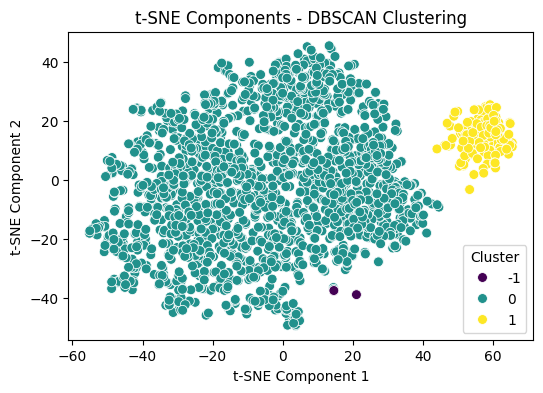

In [ ]:
dbscan = DBSCAN(eps=7, min_samples=8)
dbscan_clusters = dbscan.fit_predict(tsne_df[['t-SNE Component 1', 't-SNE Component 2']])
tsne_df['DBSCAN Cluster'] = dbscan_clusters

plt.figure(figsize=(6, 4))
sns.scatterplot(
    x='t-SNE Component 1',
    y='t-SNE Component 2',
    hue='DBSCAN Cluster',
    palette='viridis',
    data=tsne_df,
    s=50
)
plt.title('t-SNE Components - DBSCAN Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster', loc='best')
plt.show()

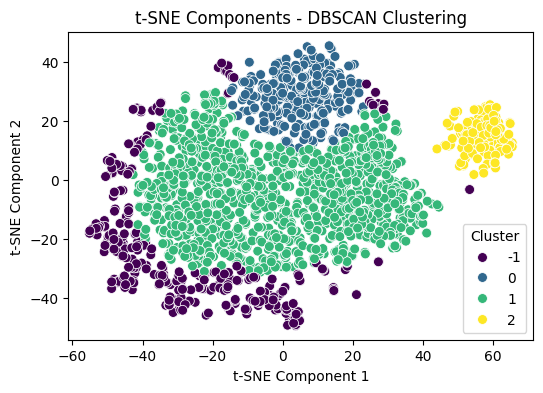

In [ ]:
dbscan = DBSCAN(eps=10.5, min_samples=100)  #10,90 or #10.5,100
dbscan_clusters = dbscan.fit_predict(tsne_df[['t-SNE Component 1', 't-SNE Component 2']])
tsne_df['DBSCAN Cluster'] = dbscan_clusters

plt.figure(figsize=(6, 4))
sns.scatterplot(
    x='t-SNE Component 1',
    y='t-SNE Component 2',
    hue='DBSCAN Cluster',
    palette='viridis',
    data=tsne_df,
    s=50
)
plt.title('t-SNE Components - DBSCAN Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster', loc='best')
plt.show()

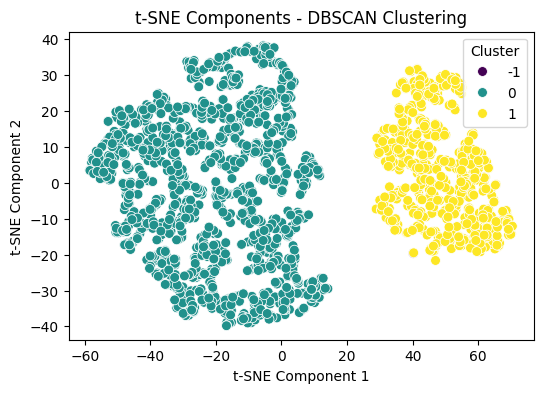

In [ ]:
dbscan = DBSCAN(eps=5, min_samples=6)
dbscan_clusters = dbscan.fit_predict(tsne_pca_only_df1[['t-SNE Component 1', 't-SNE Component 2']])
tsne_pca_only_df1['DBSCAN Cluster'] = dbscan_clusters

plt.figure(figsize=(6, 4))
sns.scatterplot(
    x='t-SNE Component 1',
    y='t-SNE Component 2',
    hue='DBSCAN Cluster',
    palette='viridis',
    data=tsne_pca_only_df1,
    s=50
)
plt.title('t-SNE Components - DBSCAN Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster', loc='best')
plt.show()

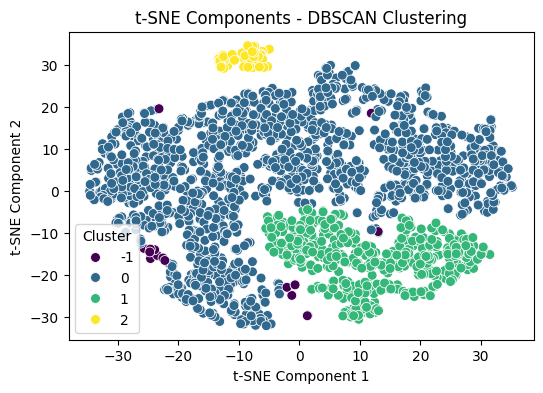

In [ ]:
dbscan = DBSCAN(eps=3.5, min_samples=15) #3.5 15
dbscan_clusters = dbscan.fit_predict(tsne_pca_only_df2[['t-SNE Component 1', 't-SNE Component 2']])
tsne_pca_only_df2['DBSCAN Cluster'] = dbscan_clusters

plt.figure(figsize=(6, 4))
sns.scatterplot(
    x='t-SNE Component 1',
    y='t-SNE Component 2',
    hue='DBSCAN Cluster',
    palette='viridis',
    data=tsne_pca_only_df2,
    s=50
)
plt.title('t-SNE Components - DBSCAN Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster', loc='best')
plt.show()

# Recommandation

In [ ]:
# Chargement des datasets
original_movies = pd.read_csv('movies.csv', sep='::', engine='python', encoding='ISO-8859-1',
                              names=['movieid', 'title', 'genres'])
original_users = pd.read_csv('users.csv', sep='::', engine='python',
                             names=['userid', 'gender', 'age', 'occupation', 'zip-code'])
original_ratings = pd.read_csv('ratings.csv', sep='::', engine='python',
                               names=['userid', 'movieid', 'rating', 'timestamp'])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Filtrage des données
min_films_threshold = 600  # Nombre maximal de films notés par utilisateur
min_ratings_threshold = 5   # Nombre minimal d'évaluations par film

# Filtrage des utilisateurs
user_ratings_counts = original_ratings['userid'].value_counts()
filtered_users = user_ratings_counts[user_ratings_counts <= min_films_threshold].index
filtered_ratings = original_ratings[original_ratings['userid'].isin(filtered_users)]

# Filtrage des films
filtered_movies = filtered_ratings['movieid'].value_counts()
filtered_movies = filtered_movies[filtered_movies >= min_ratings_threshold].index
filtered_ratings = filtered_ratings[filtered_ratings['movieid'].isin(filtered_movies)]

print("\nNombre d'utilisateurs après filtrage :", filtered_ratings['userid'].nunique())
print("Nombre de films après filtrage :", filtered_ratings['movieid'].nunique())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Nombre d'utilisateurs après filtrage : 5781
Nombre de films après filtrage : 3319


## 3. Approches de Recommandation Basées sur la Similarité


### 3.1 Recommandation Basée sur la Similarité Utilisateur

In [ ]:
# Assurez-vous que toutes les valeurs de 'rating' sont bien numériques
filtered_ratings['rating'] = pd.to_numeric(filtered_ratings['rating'], errors='coerce')

# Créer la matrice utilisateur-film, avec conversion explicite des valeurs en flottants
user_movie_matrix = filtered_ratings.pivot(index='userid', columns='movieid', values='rating').fillna(0).astype(float)

# Calcul de la similarité cosinus entre les utilisateurs
user_similarity = cosine_similarity(user_movie_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)

# Fonction de recommandation avec affichage des titres des films
def recommend_movies(user_id, num_recommendations=5):
    # Vérifier si l'utilisateur existe
    if user_id not in user_similarity_df.index:
        return f"L'utilisateur {user_id} n'existe pas dans les données filtrées."

    # Obtenir les utilisateurs similaires
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).index[1:]  # Exclure l'utilisateur lui-même

    # Recommandations basées sur la similarité
    user_ratings = user_movie_matrix.loc[user_id]
    recommended_movies = pd.Series(dtype=float)
    for similar_user in similar_users:
        similar_user_ratings = user_movie_matrix.loc[similar_user]

        # Ajouter les films non notés par l'utilisateur, pondérés par la similarité
        recommended_movies = pd.concat([recommended_movies, similar_user_ratings[user_ratings == 0] * user_similarity_df.loc[user_id, similar_user]])

    # Calculer la moyenne des scores pour chaque film et trier par ordre décroissant
    recommended_movies = recommended_movies.groupby(recommended_movies.index).mean().sort_values(ascending=False)

    # Obtenir les titres des films recommandés
    top_movie_ids = recommended_movies.head(num_recommendations).index
    recommended_movies_with_titles = original_movies[original_movies['movieid'].isin(top_movie_ids)]

    # Fusionner les scores de recommandations avec les titres des films
    final_recommendations = recommended_movies_with_titles[['movieid', 'title']].merge(
        recommended_movies.head(num_recommendations).reset_index(name='score').rename(columns={'index': 'movieid'}),
        on='movieid'
    )

    return final_recommendations[['title', 'score']]

# Tester les recommandations pour un utilisateur spécifique
user_id_example = filtered_ratings['userid'].iloc[0]
print(f"Recommandations pour l'utilisateur {user_id_example} :")
print(recommend_movies(user_id_example))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Recommandations pour l'utilisateur 1 :
                                               title     score
0                   Silence of the Lambs, The (1991)  0.238859
1  Star Wars: Episode V - The Empire Strikes Back...  0.277165
2                     Raiders of the Lost Ark (1981)  0.244006
3  Star Wars: Episode VI - Return of the Jedi (1983)  0.240380
4                             American Beauty (1999)  0.291350


### Recommandation Personnalisée Basée sur la Décomposition en Valeurs Singulières (SVD)


In [ ]:
# from surprise import Dataset, Reader, SVD
# import pandas as pd

# # Chargement des datasets (assurez-vous que les fichiers sont dans le même répertoire ou indiquez le chemin complet)
# original_movies = pd.read_csv('movies.csv', sep='::', engine='python', encoding='ISO-8859-1',
#                               names=['movieid', 'title', 'genres'], skiprows=1)
# original_ratings = pd.read_csv('ratings.csv', sep='::', engine='python',
#                                names=['userid', 'movieid', 'rating', 'timestamp'])

# # Filtrage des données
# min_films_threshold = 600  # Nombre maximal de films notés par utilisateur
# min_ratings_threshold = 5   # Nombre minimal d'évaluations par film

# # Filtrage des utilisateurs
# user_ratings_counts = original_ratings['userid'].value_counts()
# filtered_users = user_ratings_counts[user_ratings_counts <= min_films_threshold].index
# filtered_ratings = original_ratings[original_ratings['userid'].isin(filtered_users)]

# # Filtrage des films
# filtered_movies = filtered_ratings['movieid'].value_counts()
# filtered_movies = filtered_movies[filtered_movies >= min_ratings_threshold].index
# filtered_ratings = filtered_ratings[filtered_ratings['movieid'].isin(filtered_movies)]

# Ajout d'un utilisateur fictif
user_id_fictif = 9999
fictif_ratings = pd.DataFrame([
    {'userid': user_id_fictif, 'movieid': 1, 'rating': 5},
    {'userid': user_id_fictif, 'movieid': 32, 'rating': 4},
    {'userid': user_id_fictif, 'movieid': 260, 'rating': 3},
    {'userid': user_id_fictif, 'movieid': 589, 'rating': 5},
    {'userid': user_id_fictif, 'movieid': 858, 'rating': 4}
])

# Assurez-vous que les types de données de `movieid` correspondent
fictif_ratings['movieid'] = fictif_ratings['movieid'].astype(int)
original_movies['movieid'] = original_movies['movieid'].astype(int)
filtered_ratings['movieid'] = filtered_ratings['movieid'].astype(int)

# Ajout des évaluations fictives aux données filtrées
filtered_ratings = pd.concat([filtered_ratings, fictif_ratings], ignore_index=True)

# Préparation des données pour SVD
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(filtered_ratings[['userid', 'movieid', 'rating']], reader)
trainset = data.build_full_trainset()
svd = SVD()
svd.fit(trainset)

# Affichage des préférences initiales de l'utilisateur fictif
print(f"\nPréférences initiales de l'utilisateur fictif ({user_id_fictif}) :")
for rating in fictif_ratings.itertuples():
    movie_row = original_movies[original_movies['movieid'] == rating.movieid]
    if not movie_row.empty:
        movie_title = movie_row['title'].values[0]
        print(f"{movie_title} : {rating.rating} étoiles")
    else:
        print(f"Le titre pour movieid {rating.movieid} n'est pas disponible. (Titre manquant dans 'original_movies')")

# Fonction de recommandation pour l'utilisateur fictif
def recommend_movies_svd(user_id, n=5):
    # Liste des films déjà évalués par l'utilisateur fictif
    movie_ids = filtered_ratings['movieid'].unique()
    movies_to_recommend = [
        (movie_id, svd.predict(user_id, movie_id).est)
        for movie_id in movie_ids if movie_id not in fictif_ratings['movieid'].values
    ]

    # Trier les recommandations par note estimée
    recommended_movies = sorted(movies_to_recommend, key=lambda x: x[1], reverse=True)[:n]

    # Créer la liste de recommandations
    recommendations = []
    for movie_id, est_rating in recommended_movies:
        movie_row = original_movies[original_movies['movieid'] == movie_id]
        if not movie_row.empty:
            movie_title = movie_row['title'].values[0]
            recommendations.append({'title': movie_title, 'estimated_rating': est_rating})

    # Retourner les recommandations sous forme de DataFrame
    rec_df = pd.DataFrame(recommendations)
    return rec_df

# Affichage des recommandations pour l'utilisateur fictif
print(f"\nRecommandations pour l'utilisateur fictif ({user_id_fictif}) :")
print(recommend_movies_svd(user_id_fictif))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Préférences initiales de l'utilisateur fictif (9999) :
Toy Story (1995) : 5 étoiles
Twelve Monkeys (1995) : 4 étoiles
Star Wars: Episode IV - A New Hope (1977) : 3 étoiles
Terminator 2: Judgment Day (1991) : 5 étoiles
Godfather, The (1972) : 4 étoiles

Recommandations pour l'utilisateur fictif (9999) :
                              title  estimated_rating
0  Shawshank Redemption, The (1994)          4.820868
1           Schindler's List (1993)          4.679536
2                    Sanjuro (1962)          4.668301
3         When We Were Kings (1996)          4.619757
4         American History X (1998)          4.607653


## 4. Analyse Avancée et Ingénierie des Caractéristiques

### 4.1 Feature Engineering Avancé


In [ ]:
# Assurez-vous que la colonne rating est numérique
filtered_ratings['rating'] = pd.to_numeric(filtered_ratings['rating'], errors='coerce')

# Supprimez les lignes avec des NaN dans la colonne rating
filtered_ratings = filtered_ratings.dropna(subset=['rating'])

# Calcul de la note moyenne par utilisateur
user_avg_rating = filtered_ratings.groupby('userid')['rating'].mean().reset_index()
user_avg_rating.columns = ['userid', 'avg_user_rating']

# Comptage du nombre de notes par utilisateur
user_rating_count = filtered_ratings.groupby('userid').size().reset_index(name='rating_count')

# Calcul de la note moyenne par genre pour chaque utilisateur
rating_movies = pd.merge(filtered_ratings, original_movies, on='movieid')
rating_movies['genres'] = rating_movies['genres'].fillna('')
rating_movies_exploded = rating_movies.assign(genre=rating_movies['genres'].str.split('|')).explode('genre')
user_genre_avg_rating = rating_movies_exploded.groupby(['userid', 'genre'])['rating'].mean().reset_index()
user_genre_avg_rating.columns = ['userid', 'genre', 'avg_user_genre_rating']

# Encodage one-hot des genres
genres = original_movies['genres'].str.get_dummies(sep='|')

# Normalisation des notes moyennes des utilisateurs et du nombre de notes
user_features = pd.merge(user_avg_rating, user_rating_count, on='userid')
scaler = StandardScaler()
user_features[['avg_user_rating', 'rating_count']] = scaler.fit_transform(user_features[['avg_user_rating', 'rating_count']])

# Fusion des caractéristiques utilisateur
pca_data = user_features.copy()

# Ajout des notes moyennes par genre
user_genre_pivot = user_genre_avg_rating.pivot(index='userid', columns='genre', values='avg_user_genre_rating').fillna(0)
pca_data = pca_data.merge(user_genre_pivot, on='userid', how='left').fillna(0)

# Application de PCA avec ajustement dynamique de n_components
n_components = min(pca_data.shape[1] - 1, 3)  # Ajuste n_components selon le nombre de colonnes disponibles
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(pca_data.drop(['userid'], axis=1))
pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
pca_df['userid'] = pca_data['userid']

print("\nRésultats de la PCA :")
print(pca_df.head())


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Résultats de la PCA :
        PC1       PC2       PC3 userid
0 -4.148242 -3.017572  1.462992   9999
1 -2.024531 -4.606638  0.855110      1
2  4.464732 -0.422216  1.326759     10
3 -0.306212 -0.481076 -0.357038    100
4  1.729654 -2.364801 -1.100571   1000


### 4.2 Clustering des Utilisateurs dans l'Espace PCA


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


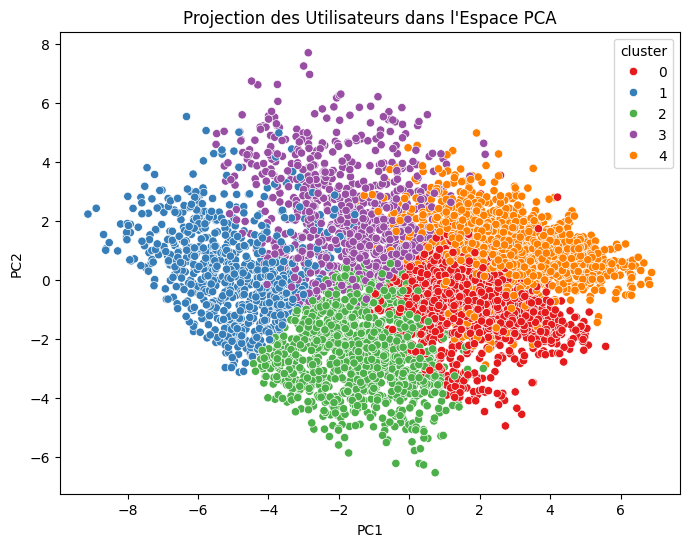

In [ ]:
# Application de K-Means sur les composantes principales
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(pca_df.drop('userid', axis=1))

# Ajouter les labels de clusters au DataFrame
pca_df['cluster'] = clusters

# Visualisation des clusters
plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df, palette='Set1')
plt.title('Projection des Utilisateurs dans l\'Espace PCA')
plt.show()

### 4.3 Recommandation Basée sur les Clusters


In [ ]:
# Fonction de recommandation basée sur les clusters
def recommend_movies_cluster(user_id, num_recommendations=5):
    # Vérifier si l'utilisateur existe
    if user_id not in pca_df['userid'].values:
        return f"L'utilisateur {user_id} n'existe pas dans les données filtrées."

    # Obtenir le cluster de l'utilisateur
    user_cluster = pca_df[pca_df['userid'] == user_id]['cluster'].values[0]

    # Obtenir les utilisateurs dans le même cluster
    users_in_cluster = pca_df[pca_df['cluster'] == user_cluster]['userid'].values

    # Obtenir les films les plus populaires dans le cluster
    cluster_ratings = filtered_ratings[filtered_ratings['userid'].isin(users_in_cluster)]
    top_movies = cluster_ratings.groupby('movieid')['rating'].mean().sort_values(ascending=False)

    # Exclure les films déjà notés par l'utilisateur
    user_rated_movies = filtered_ratings[filtered_ratings['userid'] == user_id]['movieid'].values
    top_movies = top_movies[~top_movies.index.isin(user_rated_movies)]

    # Obtenir les titres des films recommandés
    recommended_movies = original_movies[original_movies['movieid'].isin(top_movies.head(num_recommendations).index)]
    return recommended_movies[['title']]

# Exemple de recommandation
print(f"\nRecommandations basées sur les clusters pour l'utilisateur {user_id_example} :")
print(recommend_movies_cluster(user_id_example))


Recommandations basées sur les clusters pour l'utilisateur 1 :
                                                  title
1107                        Perfect Candidate, A (1996)
1309   Blood For Dracula (Andy Warhol's Dracula) (1974)
2493                                     Bandits (1997)
2774  Black Cat, White Cat (Crna macka, beli macor) ...
3212                    Brandon Teena Story, The (1998)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 5. Analyse de Réseau avec NetworkX


In [ ]:
# Analyse de réseau avec NetworkX
G = nx.Graph()
G.add_nodes_from(filtered_ratings['userid'].unique(), bipartite='users')
G.add_nodes_from(filtered_ratings['movieid'].unique(), bipartite='movies')
edges = list(zip(filtered_ratings['userid'], filtered_ratings['movieid']))
G.add_edges_from(edges)

# Calcul des mesures de centralité
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Extraction des centralités
user_degree_centrality = {n: c for n, c in degree_centrality.items() if n in filtered_ratings['userid'].unique()}
movie_degree_centrality = {n: c for n, c in degree_centrality.items() if n in filtered_ratings['movieid'].unique()}

print("\nTop utilisateurs par centralité de degré :")
print(sorted(user_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

print("\nTop films par centralité de degré :")
print(sorted(movie_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5])


## 6. Visualisation des Variables Latentes avec TSNE


In [ ]:
# Extraire les vecteurs latents
movie_ids = user_movie_matrix.columns
latent_vectors = user_movie_matrix.T.values  # Utilisation des vecteurs films par utilisateurs pour la visualisation

# Application de TSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(latent_vectors)

# Créer un DataFrame avec les résultats
latent_df = pd.DataFrame(tsne_result, columns=['TSNE-1', 'TSNE-2'], index=movie_ids)
latent_df = latent_df.merge(original_movies[['movieid', 'title', 'genres']], left_index=True, right_on='movieid')

# Visualisation des vecteurs latents
fig = px.scatter(latent_df, x='TSNE-1', y='TSNE-2', color='genres', hover_data=['title'])
fig.show()

## Optimisation des Hyperparamètres pour le Modèle SVD

In [ ]:
# Préparation des données pour SVD
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(filtered_ratings[['userid', 'movieid', 'rating']], reader)

# Division des données en ensembles d'entraînement et de test
trainset, testset = train_test_split(data, test_size=0.2)

# Définition de la grille de paramètres
param_grid = {
    'n_factors': [20, 50, 100, 150, 200, 250],
    'n_epochs': [20, 50, 70, 100, 150],
    'lr_all': [0.001, 0.002, 0.005, 0.007, 0.01],
    'reg_all': [0.01, 0.02, 0.05, 0.1, 0.15, 0.2]
}

# GridSearchCV pour optimiser SVD
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
gs.fit(data)

# Afficher les meilleurs paramètres et résultats
print("Meilleurs paramètres pour SVD :")
print(gs.best_params['rmse'])
print(f"Meilleur RMSE : {gs.best_score['rmse']:.4f}")
print(f"Meilleur MAE : {gs.best_score['mae']:.4f}")

# Entraîner le modèle SVD optimisé
svd_optimized = gs.best_estimator['rmse']
svd_optimized.fit(trainset)

# Évaluation du modèle optimisé
predictions = svd_optimized.test(testset)
accuracy.rmse(predictions)
accuracy.mae(predictions)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 8. Recommandation Basée sur la Similarité dans l'Espace PCA

In [ ]:
# Calcul de la similarité entre les utilisateurs dans l'espace PCA
pca_vectors = pca_df.drop(['userid', 'cluster'], axis=1).values
user_similarity_pca = cosine_similarity(pca_vectors)
user_similarity_pca_df = pd.DataFrame(user_similarity_pca, index=pca_df['userid'], columns=pca_df['userid'])

# Fonction de recommandation basée sur la similarité PCA
def recommend_movies_pca(user_id, num_recommendations=5):
    # Vérifier si l'utilisateur existe
    if user_id not in user_similarity_pca_df.index:
        return f"L'utilisateur {user_id} n'existe pas dans les données filtrées."

    # Obtenir les utilisateurs similaires
    similar_users = user_similarity_pca_df[user_id].sort_values(ascending=False).index[1:]  # Exclure l'utilisateur lui-même

    # Recommandations basées sur la similarité
    user_ratings = filtered_ratings[filtered_ratings['userid'] == user_id]
    user_rated_movies = user_ratings['movieid'].values

    recommended_movies = pd.Series(dtype=float)
    for similar_user in similar_users:
        similar_user_ratings = filtered_ratings[filtered_ratings['userid'] == similar_user]
        similar_user_ratings = similar_user_ratings[~similar_user_ratings['movieid'].isin(user_rated_movies)]

        # Utiliser pd.concat au lieu de append
        recommended_movies = pd.concat([
            recommended_movies,
            similar_user_ratings.set_index('movieid')['rating'] * user_similarity_pca_df.loc[user_id, similar_user]
        ])

    # Calculer la moyenne des scores pour chaque film et trier par ordre décroissant
    recommended_movies = recommended_movies.groupby(recommended_movies.index).mean().sort_values(ascending=False)

    # Obtenir les titres des films recommandés
    top_movie_ids = recommended_movies.head(num_recommendations).index
    recommended_movies_with_titles = original_movies[original_movies['movieid'].isin(top_movie_ids)]

    # Fusionner les scores de recommandations avec les titres des films
    final_recommendations = recommended_movies_with_titles[['movieid', 'title']].merge(
        recommended_movies.head(num_recommendations).reset_index(name='score').rename(columns={'index': 'movieid'}),
        on='movieid'
    )

    return final_recommendations[['title', 'score']]

# Exemple de recommandation
print(f"\nRecommandations basées sur la similarité PCA pour l'utilisateur {user_id_example} :")
print(recommend_movies_pca(user_id_example))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Recommandations basées sur la similarité PCA pour l'utilisateur 1 :
                                               title     score
0                                It Takes Two (1995)  1.569934
1                Amazing Panda Adventure, The (1995)  1.361051
2                         So Dear to My Heart (1949)  2.273032
3                          Dog of Flanders, A (1999)  1.056131
4  Mating Habits of the Earthbound Human, The (1998)  1.423582
